In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
%matplotlib inline

In [3]:
def load_dataset():
    train_dataset = h5py.File('cat_datasets/train_catvnoncat.h5',"r")
    train_x = np.array(train_dataset["train_set_x"][:])
    train_y = np.array(train_dataset["train_set_y"][:])
    
    test_dataset = h5py.File('cat_datasets/test_catvnoncat.h5',"r")
    test_x = np.array(test_dataset["test_set_x"][:])
    test_y = np.array(test_dataset["test_set_y"][:])
    
    classes = np.array(test_dataset["list_classes"][:])
    
    train_y = train_y.reshape(1,train_y.shape[0])
    test_y = test_y.reshape(1,test_y.shape[0])
    
    return train_x,train_y,test_x,test_y,classes

In [4]:
x_train,y_train,x_test,y_test,classes = load_dataset()

In [5]:
print(x_train.shape)

(209, 64, 64, 3)


In [6]:
print(y_train.shape)

(1, 209)


In [7]:
print(classes)

[b'non-cat' b'cat']


y = [0]
It is a non-cat


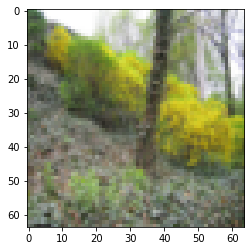

In [19]:
## Checking 

index = (np.random.randint(0,x_train.shape[0]))
plt.imshow(x_train[index])
print("y = " + str(y_train[:,index]))
print('It is a', classes[np.squeeze(y_train[:,index])].decode("utf-8"))

In [16]:
# m_train = number of samples in train
# m_test = numnber of samples in test
# num_px = (height = width) of training image
m_train  = x_train.shape[0]
m_test = x_test.shape[0]
num_px = x_test[0].shape[0]
print("Total Training images = " + str(m_train))
print("Total Test images = " + str(m_test))
print("Shape of each image = (" + str(num_px) + ", " + str(num_px) + ", " + "3)")

Total Training images = 209
Total Test images = 50
Shape of each image = (64, 64, 3)


In [38]:
# reshaping the images of both test and train to a single vector

flatten_x_train = x_train.reshape(x_train.shape[0],-1).T
flatten_x_test = x_test.reshape(x_test.shape[0],-1).T


In [37]:
print(flatten_x_train.shape)

(12288, 209)


In [39]:
# standardize/normalize our dataset as pixel value is in 0 to 255 so, 
train_x = flatten_x_train/255
test_x = flatten_x_test/255

t's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why Logistic Regression is actually a very simple Neural Network!

Mathematical expression of the algorithm:

For one example $x^{(i)}$: $$z^{(i)} = w^T x^{(i)} + b \tag{1}$$ $$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ $$ \mathcal{L}(a^{(i)}, y^{(i)}) = - y^{(i)} \log(a^{(i)}) - (1-y^{(i)} ) \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples: $$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

Key steps: In this exercise, you will carry out the following steps:

- Initialize the parameters of the model
- Learn the parameters for the model by minimizing the cost  
- Use the learned parameters to make predictions (on the test set)
- Analyse the results and conclude


4 - Building the parts of our algorithm

The main steps for building a Neural Network are:

    Define the model structure (such as number of input features)
    Initialize the model's parameters
    Loop:
        Calculate current loss (forward propagation)
        Calculate current gradient (backward propagation)
        Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call model().

In [53]:
def initializer_with_zeros(shape):
    w = np.zeros((shape,1))
    b = 0
    return w,b

In [54]:
def sigmoid(x) : 
    return 1/(1 + np.exp(-x))

In [86]:
def propogate(w,b,X,Y):
    """ 
    Cost Function (costs) and Gradients (dw,db) calculator 
    """
    
    m = X.shape[1]
    
    
    # Forward Propogation
    
    A = sigmoid(np.dot(w.T,X) + b)
    # loss function 
    cost = -1/m*(np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)))
    cost = np.squeeze(cost)
    # Backward Propogation
    dw = 1/m * (np.dot(X,((A-Y).T)))
    db = 1/m * (np.sum(A-Y))
    
    grads = {"dw":dw,"db":db}
    
    return grads,cost

In [87]:
train_x.shape

(12288, 209)

In [88]:
def optimizer(w,b,X,Y,num_iterations,learning_rate,print_cost = False) : 
    
    costs = []
    # Gradient Descent 
    
    for i in range(num_iterations) :
         
        grads,cost = propogate(w,b,X,Y) 
        
        w  = w - learning_rate * grads["dw"]
        b = b - learning_rate * grads["db"]
        
        if i  % 100 == 0 : 
            costs.append(cost)
        
        # print cost every 100th iteration
        if print_cost and i%100==0:
            print("cost after iteration %i: %:f"%(i,cost))
            
    dw = grads["dw"]
    db = grads["db"]
    params = {"w":w,"b":b}
    grads = {"dw":dw,"db":db}
    return params,grads,costs

In [89]:
def predict(w,b,X):
    m = X.shape[1]
    Y_pred = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    A = sigmoid(np.dot(w.T,X) + b)
    
    for i in range(A.shape[1]):
        Y_pred[0][i] = 1 if A[0][i]>0.5 else 0 
    return Y_pred

In [93]:
def accuracy(Y_pred,Y_train):
    return 100 - np.mean(np.abs(Y_pred - Y_train))*100

In [105]:
def model(X_train,Y_train,X_test,Y_test,num_iterations = 2000,learning_rate = 0.5,print_cost = False):
    """
    A logisitic regression cat classifier 
    """
    
    # Weights and biases initalizer with zeros
    w,b  = initializer_with_zeros(X_train.shape[0])
    
    # Running Gradient descent
    params,grads,costs = optimizer(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost = False)
    
    # Getting params from the dictionary outputted by optimizer
    w = params['w']
    b = params['b']
    
    # Predictions
    
    Y_pred_train = predict(w,b,X_train)
    Y_pred_test = predict(w,b,X_test)
    
    # Accuracy metrics
    
    train_acc = accuracy(Y_pred_train,Y_train)
    test_acc = accuracy(Y_pred_test,Y_test)
    
    print("Training Accuracy :",train_acc)
    print("Test Accuracy :",test_acc)
    
    
    d = {"costs":costs,"Y_pred_train":Y_pred_train,"Y_pred_test":Y_pred_test,
         "w":w,"b":b,"learning_rate":learning_rate,"num_iterations":num_iterations}
    
    return d

In [106]:
d = model(train_x,y_train,test_x,y_test,print_cost=True)

<ipython-input-86-9ab4c7be3567>:13: RuntimeWarning: divide by zero encountered in log
  cost = -1/m*(np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)))
<ipython-input-86-9ab4c7be3567>:13: RuntimeWarning: invalid value encountered in multiply
  cost = -1/m*(np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)))
<ipython-input-54-fb777a8a12d3>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


Training Accuracy : 100.0
Test Accuracy : 72.0


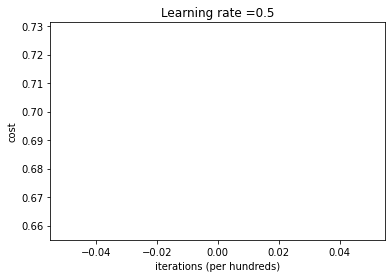

In [113]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()